In [2]:
%matplotlib inline
import collections
import json
import math
import matplotlib
import numpy as np
import scipy
import skimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from matplotlib import pyplot as plt
from PIL import Image

#import model

## Configuration

In [3]:
config = collections.namedtuple('config',[])
config.image_size = 448
config.central_fraction = 0.875
config.output_features = 2048
config.max_answers = 3000

## Data paths

In [4]:
MODEL_PATH = 'pretrained/2017-08-04_00.55.19.pth'
pretrained = torch.load(MODEL_PATH)
vocab = pretrained['vocab']

In [5]:
questions_path = 'vqa/OpenEnded_mscoco_val2014_questions.json'
answers_path = 'vqa/mscoco_val2014_annotations.json'

with open(questions_path, 'r') as fd:
    questions_json = json.load(fd)
with open(answers_path, 'r') as fd:
    answers_json = json.load(fd)
    
# For practice, we use only 1000 images from the annotations
questions_json['questions'] = questions_json['questions'][:1000]
answers_json['annotations'] = answers_json['annotations'][:1000]
    
token_to_index = vocab['question']
answer_to_index = vocab['answer']
index_to_answer = {i: a for a, i in answer_to_index.items()}

What is the table made of?
['wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood']
example_images/COCO_val2014_000000350623.jpg


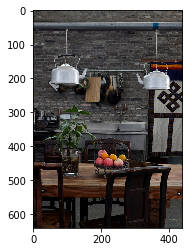

In [5]:
question = questions_json['questions'][0]['question']
print(question)
answers = [a['answer'] for a in answers_json['annotations'][0]['answers']]
print(answers)
image_path = 'example_images/COCO_val2014_{:012d}.jpg'.format(questions_json['questions'][0]['image_id'])
print(image_path)
img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.show()

## Load feature extractor (resnet152)

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, # change
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
def resnet152():
    """Constructs a ResNet-152 model."""
    model = ResNet(Bottleneck, [3, 8, 36, 3])
    return model

### extracting particular feature map from ResNet

In [7]:
class FeatureNet(nn.Module):
    def __init__(self):
        super(FeatureNet, self).__init__()
        self.model = resnet152()
        self.model.load_state_dict(torch.load('pretrained/resnet152.pth'))

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer

In [8]:
feature_net = FeatureNet().cuda()
feature_net.eval()
print('feature_net is loaded')

feature_net is loaded


### image preprocessing function

In [9]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [10]:
transform = get_transform(config.image_size, config.central_fraction)
image_path = 'example_images/COCO_val2014_{:012d}.jpg'.format(questions_json['questions'][0]['image_id'])
img = Image.open(image_path).convert('RGB')
img_data = transform(img)

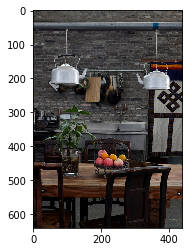

In [11]:
# original image
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


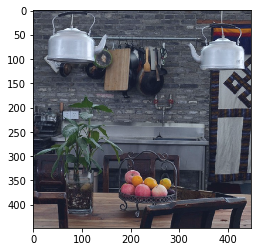

In [12]:
# processed image
processed_img = (np.array(img_data).transpose([1,2,0])) / 5 + 0.5
plt.imshow(processed_img)
plt.show()

### extracting particular feature map from ResNet

In [13]:
with torch.no_grad():
    img_var = Variable(img_data.unsqueeze(0).cuda())  # image should have a batch dimension
    feature_net.eval()
    visual_feature = feature_net(img_var)
    visual_feature = visual_feature.cpu()

In [14]:
print(visual_feature.shape)

torch.Size([1, 2048, 14, 14])


## Question preprocessing

### Exercise 1: 
implement following two functions:
we can use the dictionary 'token_to_index' as a word vocabulary

In [ ]:
"""
Exercise
"""
def process_question(question):
    """
    Implement this function
    """
    return tokenized_question

def encode_question(question, sequence_length=None):
    if sequence_length is None:
        sequence_length = len(question)
    """
    Implement this function
    """
    return q_tensor, q_length_tensor

below shows example result for the functions

In [16]:
question = questions_json['questions'][0]['question']
print('question:', question)
processed_q = process_question(question)
print('processed_q:', processed_q)
encoded_q = encode_question(processed_q, 10)
print('encoded_q:', encoded_q)

question: What is the table made of?
processed_q: ['what', 'is', 'the', 'table', 'made', 'of']
encoded_q: (tensor([ 3,  2,  1, 68, 59,  9,  0,  0,  0,  0]), tensor(6))


## Question encoding

### Exercise 2: 
Finish implementation of the following text feature extraction module

In [ ]:
"""
Exercise
"""
class TextProcessor(nn.Module):
    def __init__(self, embedding_tokens, embedding_features, lstm_features, drop=0.0):
        super(TextProcessor, self).__init__()
        self.embedding = nn.Embedding(embedding_tokens, embedding_features, padding_idx=0)
        self.drop = nn.Dropout(drop)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(input_size=embedding_features,
                            hidden_size=lstm_features,
                            num_layers=1)
        self.features = lstm_features

        self._init_lstm(self.lstm.weight_ih_l0)
        self._init_lstm(self.lstm.weight_hh_l0)
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()

        init.xavier_uniform_(self.embedding.weight)

    def _init_lstm(self, weight):
        for w in weight.chunk(4, 0):
            init.xavier_uniform_(w)

    def forward(self, q, q_len):
        """
        Implement this part
        """
        return text_feature

In [18]:
# question preprocessing
print('question 1: ', questions_json['questions'][1]['question'])
print('question 2: ', questions_json['questions'][0]['question'])
q1 = encode_question(process_question(questions_json['questions'][1]['question']), 10)
q2 = encode_question(process_question(questions_json['questions'][0]['question']), 10)
print('q1:', q1)
print('q2:', q2)

question 1:  Is the food napping on the table?
question 2:  What is the table made of?
q1: (tensor([   2,    1,   52, 5520,    7,    1,   68,    0,    0,    0]), tensor(7))
q2: (tensor([ 3,  2,  1, 68, 59,  9,  0,  0,  0,  0]), tensor(6))


In [19]:
q = torch.cat([q1[0].unsqueeze(0), q2[0].unsqueeze(0)])
q_len = torch.cat([q1[1].unsqueeze(0), q2[1].unsqueeze(0)])
print('q:', q)
print('q.shape', q.shape)
print('q_len:', q_len)

q: tensor([[   2,    1,   52, 5520,    7,    1,   68,    0,    0,    0],
        [   3,    2,    1,   68,   59,    9,    0,    0,    0,    0]])
q.shape torch.Size([2, 10])
q_len: tensor([7, 6])


In [20]:
text_encoder = TextProcessor(
    embedding_tokens=         ,   # +1 for <unknown> token at index 0
    embedding_features=300,
    lstm_features=1024,
    drop=0.5,
)

In [21]:
with torch.no_grad():
    text_encoder.eval()
    text_feature = text_encoder(q, q_len)

In [22]:
text_feature.shape

torch.Size([2, 1024])

# Attention model

### Exercise 3: 
Finish implementation of the following attention module

In [117]:
"""
Exercise
"""
class Attention(nn.Module):
    def __init__(self, v_features, q_features, mid_features, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_features, mid_features, 1, bias=False)  # let self.lin take care of bias
        self.q_lin = nn.Linear(q_features, mid_features)
        self.x_conv = nn.Conv2d(mid_features, glimpses, 1)

        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, v, q):
        """
        Implement this part
        """
        return attention

def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return tiled

In [24]:
attention_module = Attention(
    v_features=config.output_features,
    q_features=1024,
    mid_features=512,
    glimpses=2,
    drop=0.5,
)

In [25]:
# question preprocessing\
encoded_q = encode_question(process_question(questions_json['questions'][0]['question']), 10)
with torch.no_grad():
    text_encoder.eval()
    text_feature = text_encoder(encoded_q[0].unsqueeze(0), encoded_q[1].unsqueeze(0))

In [26]:
print('visual_feature.shape:', visual_feature.shape)
print('text_feature.shape:', text_feature.shape)

visual_feature.shape: torch.Size([1, 2048, 14, 14])
text_feature.shape: torch.Size([1, 1024])


In [27]:
with torch.no_grad():
    attention_module.eval()
    attention = attention_module(visual_feature, text_feature)

In [28]:
print('attention.shape:', attention.shape)

attention.shape: torch.Size([1, 2, 14, 14])


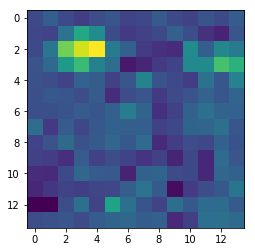

In [29]:
plt.imshow(attention[0,0])
plt.show()

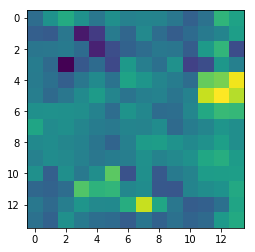

In [30]:
plt.imshow(attention[0,1])
plt.show()

## Apply attention

### Exercise 4:
Finish implementation of the following function


In [ ]:
"""
Exercise
"""
def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    """
    Implement this part
    """
    return pooled_feature

In [32]:
print('visual_feature.shape:', visual_feature.shape)
print('attention.shape:', attention.shape)
pooled_feature = apply_attention(visual_feature, attention)
print('pooled_feature.shape:', pooled_feature.shape)

visual_feature.shape: torch.Size([1, 2048, 14, 14])
attention.shape: torch.Size([1, 2, 14, 14])
pooled_feature.shape: torch.Size([1, 4096])


## VQA model

In [33]:
class VQANet(nn.Module):
    """ Re-implementation of ``Show, Ask, Attend, and Answer: A Strong Baseline For Visual Question Answering'' [0]

    [0]: https://arxiv.org/abs/1704.03162
    """

    def __init__(self, embedding_tokens):
        super(VQANet, self).__init__()
        question_features = 1024
        vision_features = config.output_features
        glimpses = 2

        self.text = TextProcessor(
            embedding_tokens=embedding_tokens,
            embedding_features=300,
            lstm_features=question_features,
            drop=0.5,
        )
        self.attention = Attention(
            v_features=vision_features,
            q_features=question_features,
            mid_features=512,
            glimpses=2,
            drop=0.5,
        )
        self.classifier = Classifier(
            in_features=glimpses * vision_features + question_features,
            mid_features=1024,
            out_features=config.max_answers,
            drop=0.5,
        )

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
        
        a = self.attention(v, q)
        
        self.attention_score = 
        v = 

        combined = 
        answer = 
        return answer


class Classifier(nn.Sequential):
    def __init__(self, in_features, mid_features, out_features, drop=0.0):
        super(Classifier, self).__init__()
        self.add_module('drop1', nn.Dropout(drop))
        self.add_module('lin1', nn.Linear(in_features, mid_features))
        self.add_module('relu', nn.ReLU())
        self.add_module('drop2', nn.Dropout(drop))
        self.add_module('lin2', nn.Linear(mid_features, out_features))

In [34]:
vqa_net = VQANet(embedding_tokens=len(vocab['question']) + 1)   # +1 for <unknown> token at index 0
vqa_net.eval()

state_dict = {}
for k, v in pretrained['weights'].items():
    state_dict[k.split('module.')[1]] = v
vqa_net.load_state_dict(state_dict)

## Prediction

In [35]:
question = questions_json['questions'][0]['question']
print('question:', question)
processed_q = process_question(question)
print('processed_q:', processed_q)
encoded_q = encode_question(processed_q)
print('encoded_q:', encoded_q)

answers = [a['answer'] for a in answers_json['annotations'][0]['answers']]
print('answers:', answers)
image_path = 'example_images/COCO_val2014_{:012d}.jpg'.format(questions_json['questions'][0]['image_id'])
print('image_path:', image_path)

question: What is the table made of?
processed_q: ['what', 'is', 'the', 'table', 'made', 'of']
encoded_q: (tensor([ 3,  2,  1, 68, 59,  9]), tensor(6))
answers: ['wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood']
image_path: example_images/COCO_val2014_000000350623.jpg


In [36]:
transform = get_transform(config.image_size, config.central_fraction)
img = Image.open(image_path).convert('RGB')
img_data = transform(img)

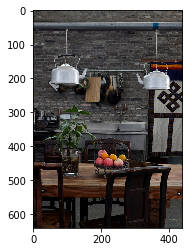

In [37]:
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


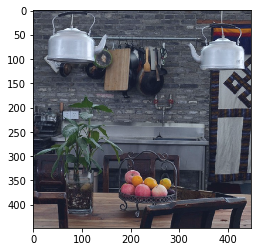

In [38]:
processed_img = (np.array(img_data).transpose([1,2,0])) / 5 + 0.5
plt.imshow(processed_img)
plt.show()

In [39]:
with torch.no_grad():
    feature_net.eval()
    feature_net.cuda()
    img_var = Variable(img_data.unsqueeze(0).cuda())  # image should have a batch dimension
    v = feature_net(img_var)

In [40]:
with torch.no_grad():
    vqa_net.eval()
    vqa_net.cuda()
    v = Variable(v.cuda())
    q = Variable(encoded_q[0].unsqueeze(0).cuda())
    q_len = Variable(encoded_q[1].unsqueeze(0).cuda())
    logit = vqa_net(v, q, q_len)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


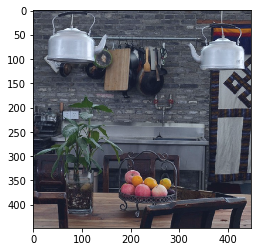

question: What is the table made of?
answer_index: 20
answer: wood


In [41]:
processed_img = (np.array(img_data).transpose([1,2,0])) / 5 + 0.5
plt.imshow(processed_img)
plt.show()
print('question:', question)
answer_index = logit.cpu().squeeze().argmax().item()
print('answer_index:', answer_index)
answer = index_to_answer[answer_index]
print('answer:', answer)

## Attention visualization

### Exercise 5:
Finish implementation of the following function

In [ ]:
"""
Exercise
"""
def attention_score_map(att):
    b, n, w, h = att.shape
    """
    Implement this part
    """
    return att_score

In [43]:
att = vqa_net.attention_score
att_score = attention_score_map(att)

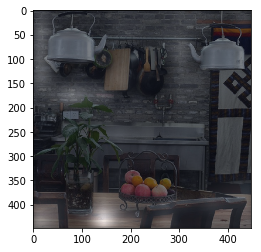

In [44]:
img_h, img_w, img_c = processed_img.shape

att_img = skimage.transform.resize(att_score[0], [img_h, img_w])
att_img = scipy.ndimage.filters.gaussian_filter(att_img, [5, 5], mode='constant')

plt.imshow(processed_img * 0.5 + np.expand_dims(att_img, -1) * 10.0)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


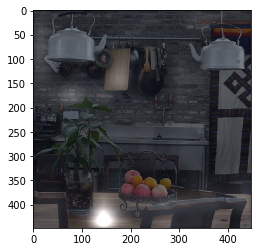

In [45]:
img_h, img_w, img_c = processed_img.shape

att_img = skimage.transform.resize(att_score[1], [img_h, img_w])
att_img = scipy.ndimage.filters.gaussian_filter(att_img, [5, 5], mode='constant')

plt.imshow(processed_img * 0.5 + np.expand_dims(att_img, -1) * 10.0)
plt.show()